# 1️⃣ Описание задачи, установка и импорт необходимых библиотек

## 1️⃣ Постановка задачи

Каршеринговая компания с крупным автопарком пользуется популярностью благодаря удобному сервису и хорошим метрикам. Однако, из-за активного износа и агрессивного вождения машин, они часто выходят из строя.

Для предотвращения этого, главный бригадир ремонта предложил оптимизировать обход машин, используя прогнозирование вероятности поломок на основе исторических данных о поездках.

С помощью команды Data Engineer'ов и Data Scientist'а компания планирует разработать систему, которая позволит эффективно обслуживать автопарк, фокусируясь на наиболее подверженных поломкам автомобилях.

Описание некоторых признаков

*   `car_id`- идентификатор машины
*   `model` / `car_type` / `fuel_type` - марка, класс и тип топлива машины;
*   `car_rating` / `riders` - общий рейтинг  и общее число поездок к концу 2021-го кода;
*   `year_to_start` / `year_to_work` - года выпуска машины и начала работы в автопарке;
*   `main_city` - город пребывания машины (Москва или Питер);
*   `target_reg` - количество дней до поломки.

Основная задача: научиться максимально точно предсказывать количество дней до поломки через обучение трёх основных моделей градиентного бустинга: `CatBoost`, `LightGBM` и `XGBoost`.

## 2️⃣ Установка и импорт библиотек

In [ ]:
!pip install catboost lightgbm xgboost category_encoders -q

In [ ]:
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from catboost import CatBoostRegressor, Pool

import lightgbm as lgb
from lightgbm import Dataset, LGBMRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

import time

RANDOM_STATE = 73

In [ ]:
# результаты скорингов моделей

results = []

Определим сразу все функции, которыми мы будем неоднократно пользоваться.

In [ ]:
# определение функции для вычисления RMSE
def rmse(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
# основная функция для тренировки сразу всех трёх моделей бустинга

def train_model(algorithm,
                X,
                y,
                early_stopping_rounds=150,
                init_params={},
                log_y=False,
                random_seed=RANDOM_STATE):

    scores = []

    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

    cat_cols = X.columns[X.dtypes == 'object']
    cat_cols_idx = [i for i, dtype in enumerate(X.dtypes) if dtype == 'object']

    for num_fold, (train_index, val_index) in enumerate(kf.split(X)):

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        if algorithm != 'CatBoostRegressor':

            if algorithm == 'XGBoost':

                train_data = xgb.DMatrix(X_train, label=y_train)
                eval_data = xgb.DMatrix(X_val, label=y_val)

                if len(init_params) == 0:
                    init_params = {'boosting_type': 'goss',
                                   'random_state': random_seed}

                model = xgb.train(params=init_params,
                                  dtrain=train_data,
                                  evals=[(train_data, 'dtrain'),
                                  (eval_data, 'dtest')],
                                  verbose_eval=False,
                                  early_stopping_rounds=early_stopping_rounds)

                X_val = eval_data

            else:
                train_data = lgb.Dataset(X_train, label=y_train)
                eval_data = lgb.Dataset(X_val, label=y_val,
                                        reference=train_data)

                if len(init_params) == 0:
                    init_params = {'booster': 'dart',
                                   'random_state': random_seed}

                model = lgb.train(params=init_params,
                                  train_set=train_data,
                                  valid_sets=(eval_data),
                                  categorical_feature=cat_cols)

        else:

            train_data = Pool(data=X_train, label=y_train,
                              cat_features=cat_cols_idx)
            eval_data = Pool(data=X_val, label=y_val,
                             cat_features=cat_cols_idx)

            model = CatBoostRegressor(verbose=0,
                                      random_state=random_seed,
                                      cat_features=cat_cols_idx,
                                      **init_params)

            model.fit(train_data,
                      eval_set=eval_data,
                      early_stopping_rounds=early_stopping_rounds)
        if not log_y:
            y_pred = model.predict(X_val)
            rmse_score = mean_squared_error(y_val, y_pred) ** 0.5
        else:
            y_pred = np.exp(model.predict(X_val))
            rmse_score = mean_squared_error(np.exp(y_val), y_pred) ** 0.5
        scores.append(rmse_score)

    return np.round(np.mean(scores), 5), model

In [ ]:
# функция для кодировки категориальных признаков и масштабирования данных

def encoder_scaler(X, y, encoder, scaler):

    cat_cols = X.columns[X.dtypes == 'object']

    encoders = {'OrdinalEncoder': OrdinalEncoder(cols=cat_cols),
                'TargetEncoder': TargetEncoder(cols=cat_cols),
                'LeaveOneOutEncoder': LeaveOneOutEncoder(cols=cat_cols)}

    scalers = {'MinMaxScaler': MinMaxScaler(),
               'StandardScaler': StandardScaler(),
               'RobustScaler': RobustScaler()}

    transformer = Pipeline([
       ('encoder_', encoders[encoder]),
       ('scaler_', scalers[scaler])
       ])

    transformed_data = pd.DataFrame(transformer.fit_transform(X, y),
                                    columns=transformer.named_steps['encoder_']
                                    .get_feature_names_out())

    return transformed_data

In [ ]:
# функция для выполнения первичного baseline предсказания

def make_baseline_prediction(X, y, log_y=False):
    models = ['XGBoost', 'LightGBM', 'CatBoostRegressor']
    encoders = ['OrdinalEncoder', 'TargetEncoder', 'LeaveOneOutEncoder']
    scalers = ['MinMaxScaler', 'StandardScaler', 'RobustScaler']

    models_score = []

    for model in models:
        for encoder in encoders:
            for scaler in scalers:
                X = encoder_scaler(X, y, encoder, scaler)
                RMSE_score, _ = train_model(model, X, y, log_y=log_y)
                models_score.append((model, encoder, scaler, RMSE_score))

    RMSE_score_catboost_default, _ = train_model('CatBoostRegressor', X, y, log_y=log_y)
    models_score.append(('CatBoostRegressor',
                         'no','no',
                         RMSE_score_catboost_default))

    return models_score

In [ ]:
# функция для подбора оптимальных гиперпараметров модели

def RandomSearchCV(X, y, param_grid, model, n_iter=30):

    grid_search = RandomizedSearchCV(model,
                                     param_distributions=param_grid,
                                     n_iter=n_iter,
                                     cv=3,
                                     scoring=rmse_scorer)
    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    return best_params, best_score

# 2️⃣  Разведочный анализ данных (EDA), подготовка к обучению

## 1️⃣ Загрузка датасетов и исследование данных

In [ ]:
train_df = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv')

RANDOM_STATE = 73 # зафиксируем случайность

In [ ]:
train_df = train_df.drop(['target_class', 'car_id', 'deviation_normal_count'], axis=1) # удалим ненужные признаки

# выделим категориальне и числовые признаки
cat_cols = train_df.columns[train_df.dtypes == 'object']
num_cols = train_df.columns[train_df.dtypes != 'object']

cat_cols_idx = [i for i, dtype in enumerate(train_df.dtypes) if dtype == 'object']
num_cols_idx = [i for i, dtype in enumerate(train_df.dtypes) if dtype != 'object']

In [ ]:
train_df.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,user_uniq
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,4.737759,1.214131e+07,0.1,180.855726,0.023174,170
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,4.480517,1.803909e+07,0.0,187.862734,12.306011,174
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,4.768391,1.588366e+07,0.1,102.382857,2.513319,173
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,3.880920,1.651883e+07,0.1,172.793237,-5.029476,170
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,4.181149,1.398317e+07,0.1,203.462289,-14.260456,171


In [ ]:
test_df.shape

(1913, 16)

Рассмотрим количество пропусков в данных

In [ ]:
for c in train_df.columns:
  print(c + ':', train_df[c].isna().sum())

model: 0
car_type: 0
fuel_type: 0
car_rating: 0
year_to_start: 0
riders: 0
year_to_work: 0
target_reg: 0
mean_rating: 0
distance_sum: 0
rating_min: 0
speed_max: 0
user_ride_quality_median: 0
user_uniq: 0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   model                     2337 non-null   object 
 1   car_type                  2337 non-null   object 
 2   fuel_type                 2337 non-null   object 
 3   car_rating                2337 non-null   float64
 4   year_to_start             2337 non-null   int64  
 5   riders                    2337 non-null   int64  
 6   year_to_work              2337 non-null   int64  
 7   target_reg                2337 non-null   float64
 8   mean_rating               2337 non-null   float64
 9   distance_sum              2337 non-null   float64
 10  rating_min                2337 non-null   float64
 11  speed_max                 2337 non-null   float64
 12  user_ride_quality_median  2337 non-null   float64
 13  user_uniq                 2337 non-null   int64  
dtypes: float

Видим, что у нас ни в одном из признаков нет пропусков, у нас есть 3 категориальных признака: `fuel_type`, `model`, `car_type`.

Посмотрим на количество значений в каждом категориальном признаке.

In [ ]:
for c in train_df.columns:
    if train_df[c].dtype == 'object':
          print(c + ':', len(train_df[c].unique()))

model: 26
car_type: 4
fuel_type: 2


Более детально взглянем на все колонки в тренировочных данных.

In [ ]:
train_df.sample(10)

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,user_uniq
1006,Kia Rio X,economy,petrol,4.44,2011,629,2016,33.81,4.282989,1.202885e+07,0.00,182.701443,-0.802696,171
798,Renault Kaptur,standart,petrol,3.60,2015,82153,2018,26.12,4.168563,1.751768e+07,0.00,176.204742,-0.571031,172
600,Smart ForTwo,economy,petrol,4.28,2016,97182,2020,28.93,4.155230,1.590868e+07,0.10,163.804557,22.570944,172
111,Kia Rio X,economy,petrol,2.20,2012,22872,2022,23.03,4.699425,1.313794e+07,0.10,126.009496,-0.583736,171
1499,Kia Rio X-line,economy,petrol,5.48,2014,59615,2019,50.89,4.137356,5.878477e+06,0.10,185.089714,3.957169,173
344,MINI CooperSE,business,electro,4.74,2012,30175,2015,44.57,5.424943,1.069666e+07,0.10,108.724297,-22.203868,174
30,Renault Sandero,standart,petrol,3.80,2011,3028,2021,32.86,3.916207,1.571316e+07,0.00,185.339612,2.023616,172
508,Mercedes-Benz E200,business,petrol,3.92,2012,23853,2018,31.82,5.347011,1.774484e+07,0.15,123.242572,17.715250,172
190,Hyundai Solaris,economy,petrol,4.12,2014,56308,2017,53.93,4.609598,1.137751e+07,0.10,152.198802,10.065974,174
395,Audi Q3,premium,petrol,3.94,2013,44650,2019,58.43,4.336322,1.184413e+07,0.10,116.563562,8.863727,171


## 2️⃣ Корреляционный анализ признаков

Далее проведём анализ признаков, используя в том числе специальные способы фильтрации.

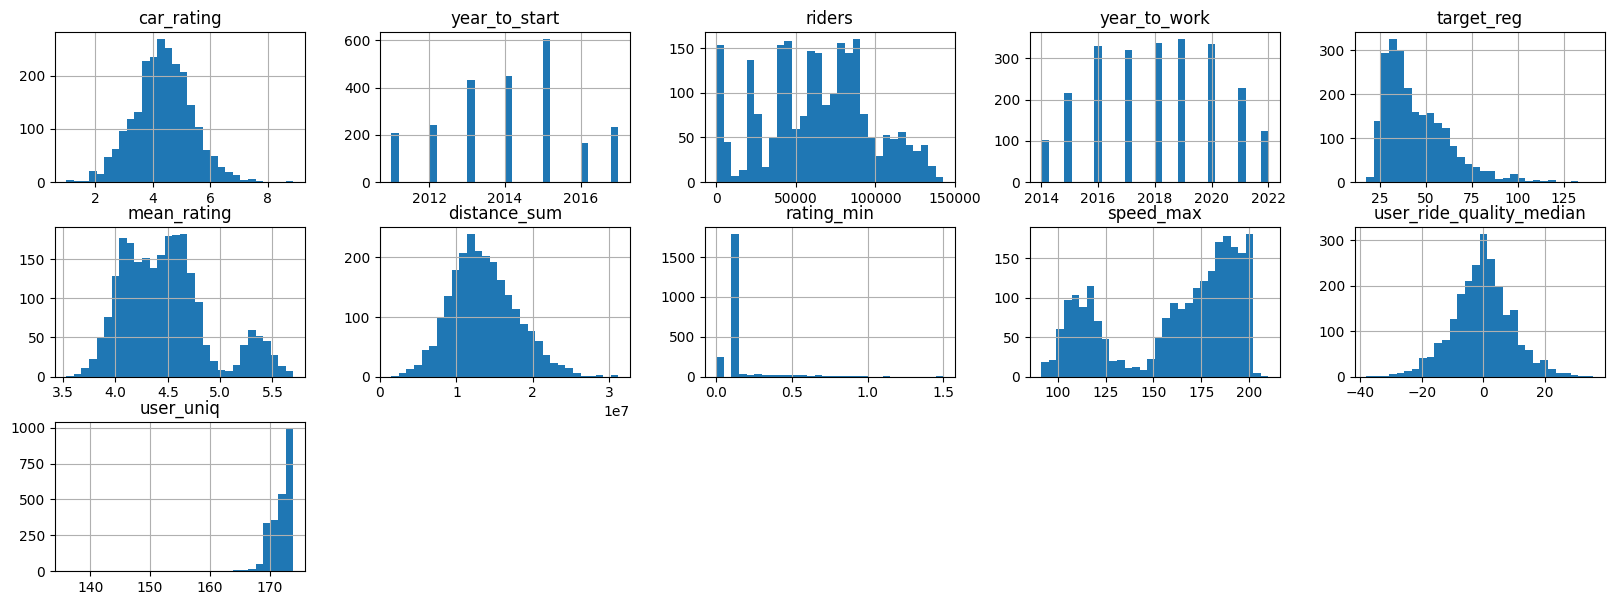

In [ ]:
train_df.hist(figsize = (20, 7), layout = (-1, 5), bins=30);

Посмотрим на распределение целевой переменной `target_reg`.

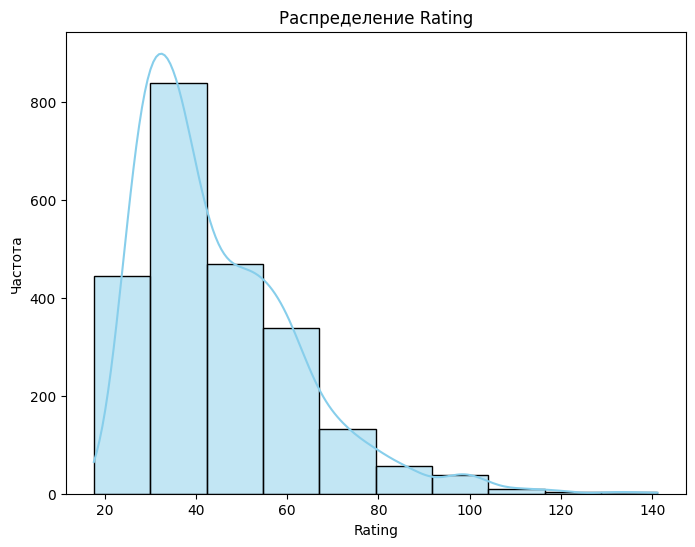

Среднее: 44.94738125802311
Медиана: 40.01
Стандартное отклонение: 17.64753265251113


In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(train_df['target_reg'], kde=True, color='skyblue', bins=10)
plt.title('Распределение Rating')
plt.xlabel('Rating')
plt.ylabel('Частота')
plt.show()

mean_target = train_df['target_reg'].mean()
median_target = train_df['target_reg'].median()
std_target = train_df['target_reg'].std()

print('Среднее:', mean_target)
print('Медиана:', median_target)
print('Стандартное отклонение:', std_target)

Прологарифмируем целевую переменную и ещё раз посмотрим на распределение.

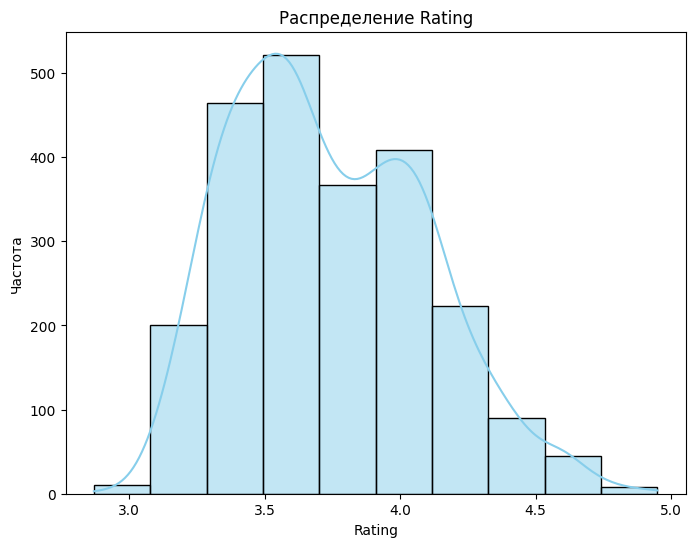

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(np.log(train_df['target_reg']), kde=True, color='skyblue', bins=10)
plt.title('Распределение Rating')
plt.xlabel('Rating')
plt.ylabel('Частота')
plt.show()

Отчеливо видим, что распределение целевой переменной `target_reg` имеет логонормальный вид.

car_rating


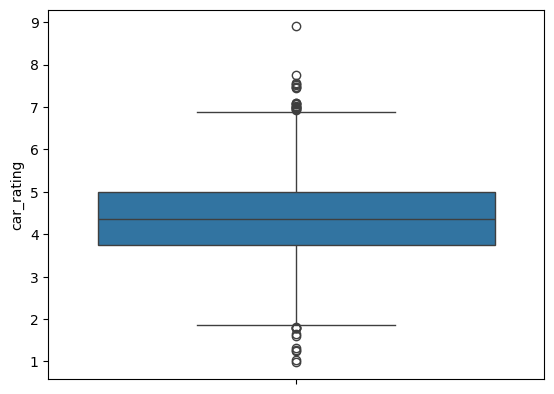

year_to_start


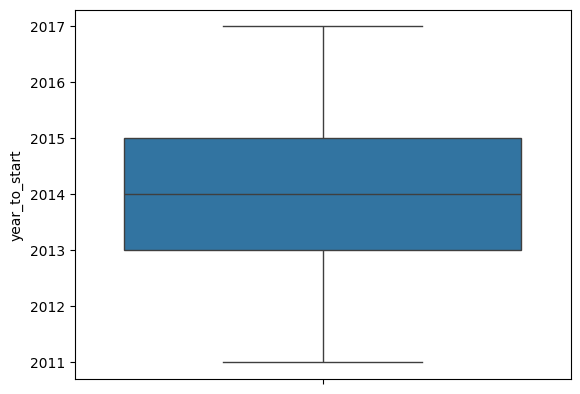

riders


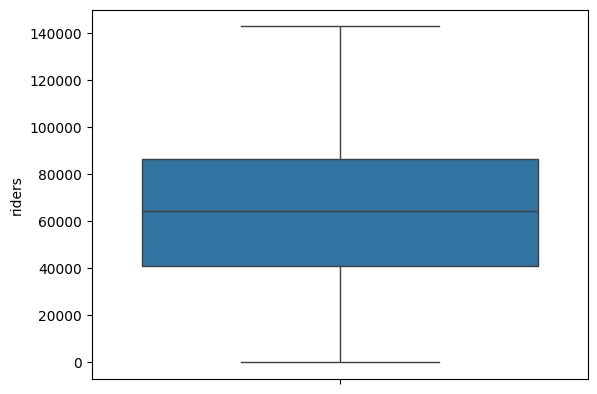

year_to_work


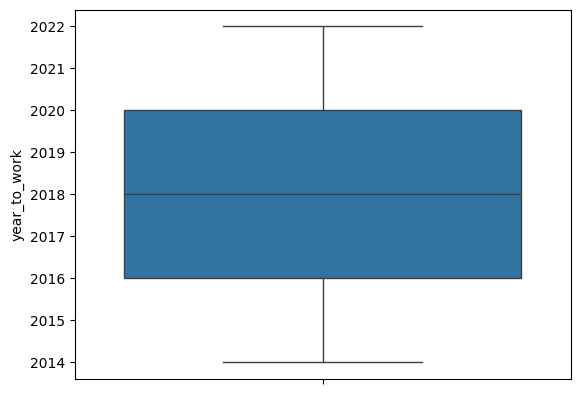

target_reg


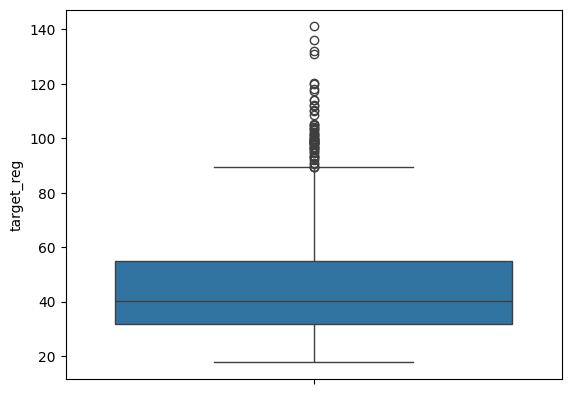

mean_rating


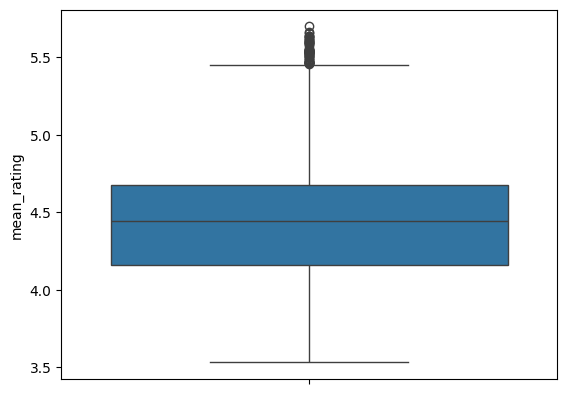

distance_sum


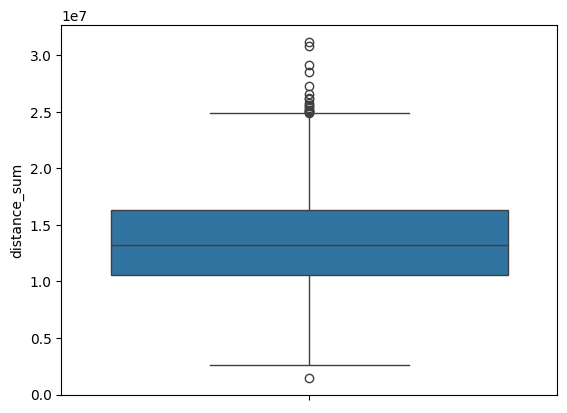

rating_min


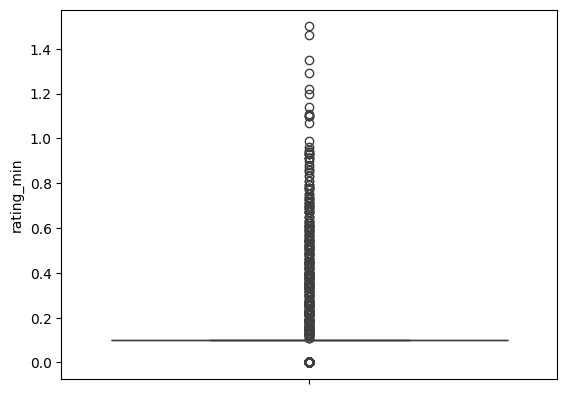

speed_max


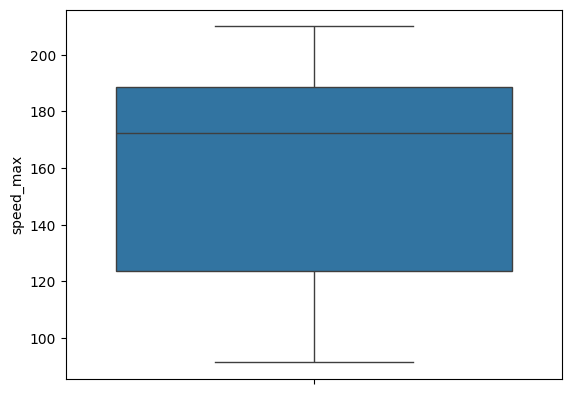

user_ride_quality_median


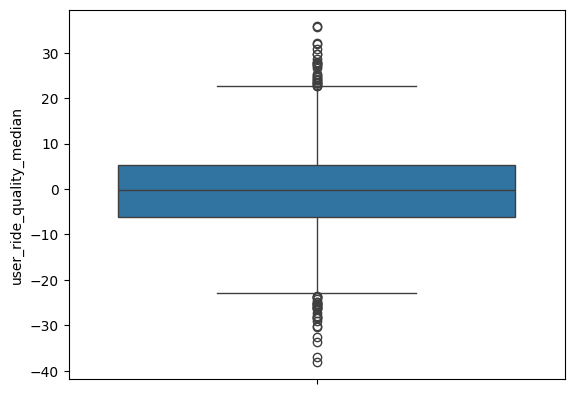

user_uniq


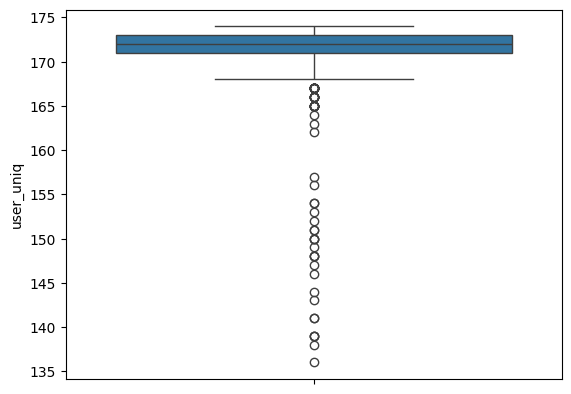

In [ ]:
for col in num_cols:
    print(col)
    sns.boxplot(train_df[col])
    plt.show();

Имеются выбросы в следующих признаках: `car_rating`, `target_reg`, `mean_rating`, `distance_sum`, `rating_min`, `user_ride_quality_median`, `user_uniq`.

### 1️⃣ Phik-корреляция

Установим требуемое расширение и проведём анализ фич.

In [ ]:
!pip install phik -q

In [ ]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq']


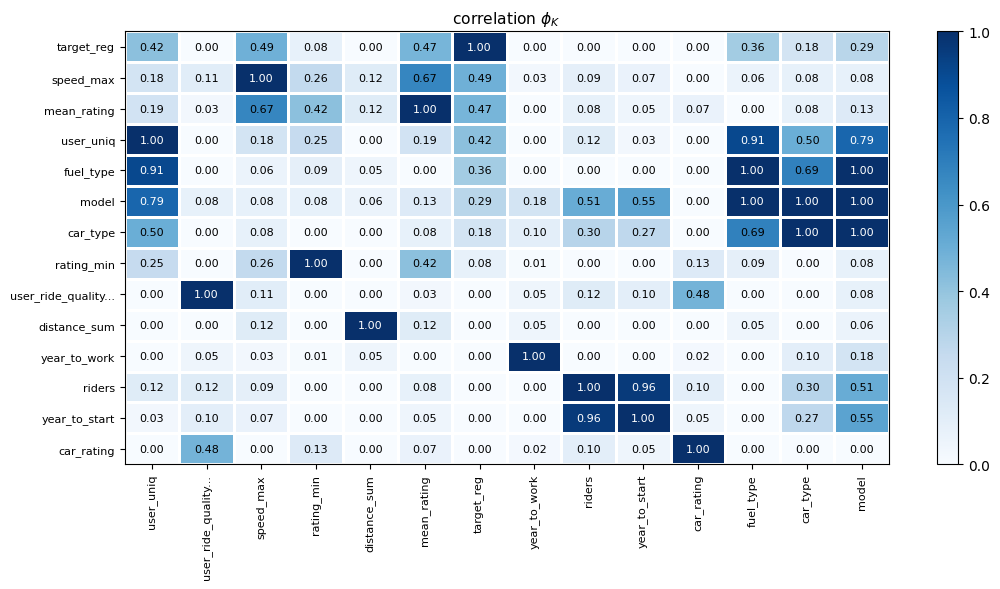

In [ ]:
phik_overview = train_df.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq']


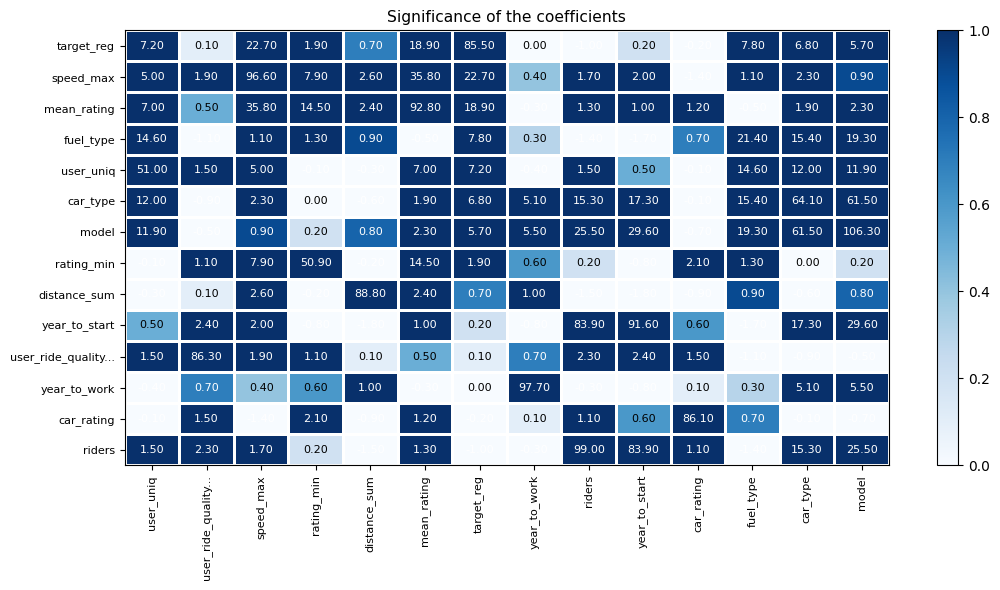

In [ ]:
significance_overview = train_df.significance_matrix().fillna(0).round(1).sort_values('target_reg')

plot_correlation_matrix(significance_overview.values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title="Significance of the coefficients",
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

С целевой переменной `target_reg` имеем 7 коррелирующих признаков: `speed_max`, `mean_rating`, `fuel_type`, `user_uniq`, `car_type`, `model`, `rating_min`, `distance_sum`.

### 2️⃣ Feature importance


В рамках разведочного анализа данных обучим модель CatBoostRegressor для определения важности признаков, по мнению модели.

In [ ]:
X_cor = train_df.drop('target_reg', axis=1)
y_cor = train_df['target_reg']

X_train_cor, X_test_cor, y_train_cor, y_test_cor = train_test_split(X_cor,
                                                                    y_cor,
                                                                    test_size=0.25,
                                                                    random_state=RANDOM_STATE)

default_model = CatBoostRegressor(random_state=RANDOM_STATE,
                                  early_stopping_rounds=150,
                                  verbose=250,
                                  cat_features=cat_cols_idx).fit(X_train_cor,
                                                                 y_train_cor,
                                                                 eval_set=(X_test_cor,
                                                                           y_test_cor))

Learning rate set to 0.055607
0:	learn: 17.6721338	test: 15.9681669	best: 15.9681669 (0)	total: 6.31ms	remaining: 6.3s
250:	learn: 9.2123362	test: 11.0093990	best: 10.9103156 (123)	total: 943ms	remaining: 2.81s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 10.91031559
bestIteration = 123

Shrink model to first 124 iterations.


In [ ]:
# посмотрим на важность признаков катбуста
default_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,speed_max,42.536213
1,mean_rating,28.003315
2,rating_min,11.424966
3,car_type,3.145717
4,user_uniq,2.587601
5,model,2.463498
6,fuel_type,2.130989
7,distance_sum,1.833714
8,year_to_work,1.695860
9,user_ride_quality_median,1.374591


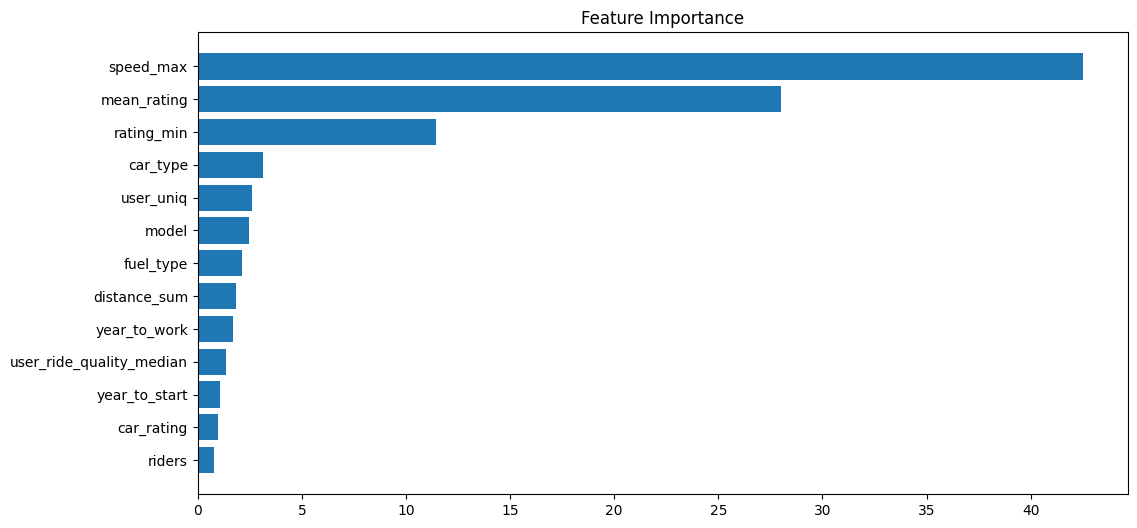

In [ ]:
feature_importance = default_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train_cor.columns)[sorted_idx])
plt.title('Feature Importance');

По мнению модели CatBoostRegressor, наиболее важные признаки: `speed_max`, `mean_rating`, `rating_min`, `riders`, `distance_sum`, `car_rating`, `user_ride_quality_median`, `model`, `user_uniq`, `car_type`, `year_to_work`, `fuel_type`, `year_to_start`.

### 3️⃣ Permutation importance

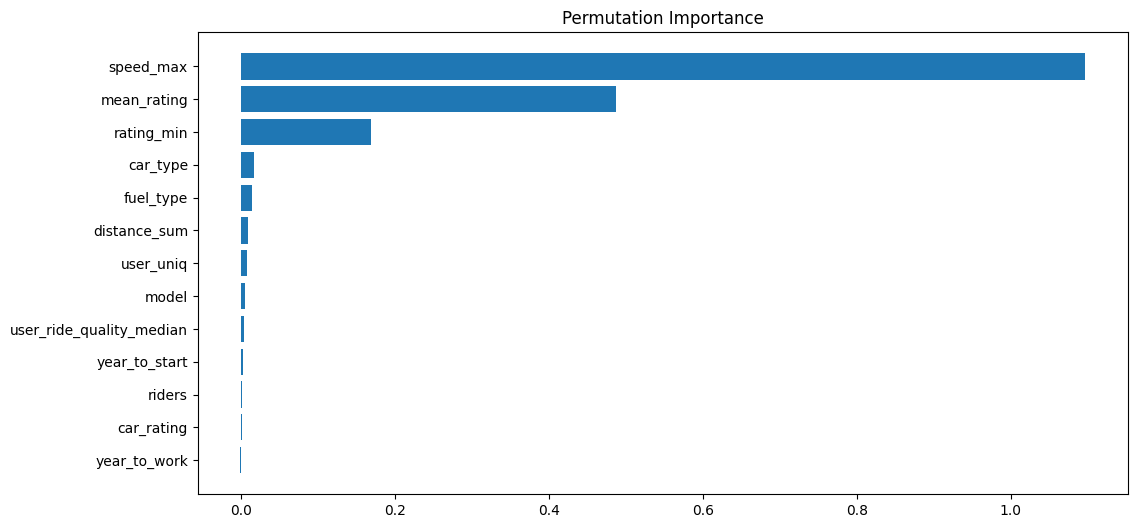

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(default_model, X_test_cor, y_test_cor, n_repeats=10, random_state=RANDOM_STATE)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_cor.columns)[sorted_idx])
plt.title('Permutation Importance');

По мнению Permutance Importance, наиболее важные признаки: `speed_max`, `mean_rating`, `rating_min`, `car_type`, `distance_sum`, `fuel_type`, `user_uniq`.

### 4️⃣ SHAP values

In [ ]:
!pip install shap -q

In [ ]:
import shap

# Посмотрим на SHAP values
explainer = shap.TreeExplainer(default_model)

val_dataset = Pool(data=X_test_cor, label=y_test_cor, cat_features=cat_cols_idx)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test_cor, max_display = 25)

import shap

# Посмотрим на SHAP values
explainer = shap.TreeExplainer(default_model)

val_dataset = Pool(data=X_test_cor, label=y_test_cor, cat_features=cat_cols_idx)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test_cor, max_display = 25)



Интерпретация результатов SHAP values: самые важные признаки `speed_max`, `mean_rating`, `rating_sum`, `car_type`, `distance_sum`, `user_uniq`. Чем выше максимальная скорость скорость автомобиля и чем выше средний и минимальный рейтинг водителя (`mean_rating` и `rating_min` соотв.), тем меньше дней останется до поломки автомобиля.

### 5️⃣ CatBoost Feature Selection

In [ ]:
summary = default_model.select_features(X_train_cor, y_train_cor,
                      eval_set=(X_test_cor, y_test_cor),
                      features_for_select='0-12',
                      num_features_to_select=8,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent')

summary = default_model.select_features(X_train_cor, y_train_cor,
                      eval_set=(X_test_cor, y_test_cor),
                      features_for_select='0-12',
                      num_features_to_select=8,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent')



In [ ]:
# Посмотрим на список отобранных фичей (не отранжирован по важности)
print(summary['selected_features_names'])
# И на лучшее значение лосса
print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

['car_type', 'fuel_type', 'riders', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_uniq']
Best loss: 10.877274163322497


По мнению рекурсивного метода `RecursiveByShapValues`, встроенного в CatBoost имеем, что важные признаки `car_type`, `fuel_type`, `riders`, `mean_rating`, `distance_sum`, `rating_min`, `speed_max`, `user_uniq`.

### 6️⃣ Boruta

Наконец, посмотрим на важности наших признаков, по мнению фреймворка Boruta.

In [ ]:
!pip install boruta -q

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

Так как Boruta работает только с моделью RandomForestRegressor, то закодируем наши категориальные признаки.

In [ ]:
X_train_one_hot = pd.get_dummies(X_train_cor[cat_cols])
X_train_cor_one_hot = pd.concat((X_train_cor.drop(columns=cat_cols), X_train_one_hot), axis=1).fillna(0)
X_train_cor_one_hot.head()

,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,user_uniq,...,model_VW Polo,model_VW Polo VI,model_VW Tiguan,model_Volkswagen ID.4,car_type_business,car_type_economy,car_type_premium,car_type_standart,fuel_type_electro,fuel_type_petrol
515,2.72,2013,37481,2021,4.430977,2.135104e+07,0.0,173.428116,-5.366843,172,...,0,0,0,0,0,0,0,1,0,1
1403,4.42,2017,139872,2017,3.987816,1.352270e+07,0.1,181.831892,-14.154620,169,...,0,0,0,0,0,0,1,0,0,1
83,3.42,2012,22261,2014,4.568678,6.596599e+06,0.1,99.408087,-0.487151,173,...,0,1,0,0,0,1,0,0,0,1
1116,5.56,2012,25972,2016,4.132529,2.519559e+07,0.1,187.647219,-8.710176,173,...,0,0,0,0,0,0,0,1,0,1
671,3.88,2017,110040,2018,4.485402,1.028764e+07,0.0,183.836060,7.398393,171,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
###initialize Boruta
forest = RandomForestRegressor(
   n_jobs = -1,
   max_depth = 3
)
boruta = BorutaPy(
   estimator = forest,
   n_estimators = 'auto',
   max_iter = 8, # number of trials to perform
    verbose=1
)

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_train_cor_one_hot), np.array(y_train_cor))
### print results
green_area = X_train_cor_one_hot.columns[boruta.support_].to_list()
blue_area = X_train_cor_one_hot.columns[boruta.support_weak_].to_list()
red_area = X_train_cor_one_hot.columns[~(boruta.support_ | boruta.support_weak_)].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
print('features in the red area:', red_area)

Iteration: 1 / 8
Iteration: 2 / 8
Iteration: 3 / 8
Iteration: 4 / 8
Iteration: 5 / 8
Iteration: 6 / 8
Iteration: 7 / 8


BorutaPy finished running.

Iteration: 	8 / 8
Confirmed: 	0
Tentative: 	5
Rejected: 	0
features in the green area: []
features in the blue area: ['mean_rating', 'rating_min', 'speed_max', 'user_uniq', 'car_type_premium']
features in the red area: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'distance_sum', 'user_ride_quality_median', 'model_Audi A3', 'model_Audi A4', 'model_Audi Q3', 'model_BMW 320i', 'model_Fiat 500', 'model_Hyundai Solaris', 'model_Kia Rio', 'model_Kia Rio X', 'model_Kia Rio X-line', 'model_Kia Sportage', 'model_MINI CooperSE', 'model_Mercedes-Benz E200', 'model_Mercedes-Benz GLC', 'model_Mini Cooper', 'model_Nissan Qashqai', 'model_Renault Kaptur', 'model_Renault Sandero', 'model_Skoda Rapid', 'model_Smart Coupe', 'model_Smart ForFour', 'model_Smart ForTwo', 'model_Tesla Model 3', 'model_VW Polo', 'model_VW Polo VI', 'model_VW Tiguan'

Зелёная зона оказалась пуста. В синей зоне имеем следующие признаки: `car_rating`, `riders`, `mean_rating`, `distance_sum`, `rating_min`, `speed_max`, `user_uniq`,`car_type`, `fuel_type`, `model`.

### 7️⃣ Предварительные выводы корреляционного анализа

Подведём некоторые итоги и наглядно покажем, какие признаки по мнению разных методов анализа признаков важны.

In [ ]:
Phik = {'speed_max', 'mean_rating', 'fuel_type', 'user_uniq', 'car_type', 'model', 'rating_min', 'distance_sum'}
FI = {'speed_max', 'mean_rating', 'rating_min', 'riders', 'distance_sum', 'car_rating', 'user_ride_quality_median', 'model', 'user_uniq', 'car_type', 'year_to_work', 'fuel_type', 'year_to_start'}
PI = {'speed_max', 'mean_rating', 'rating_min', 'car_type', 'distance_sum', 'fuel_type', 'user_uniq'}
SHAP = {'speed_max', 'mean_rating', 'rating_min', 'car_type', 'distance_sum', 'user_uniq', 'fuel_type', 'model'}
CBFS = {'car_type', 'fuel_type', 'riders', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_uniq'}
Boruta = {'car_rating', 'riders', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_uniq', 'car_type', 'fuel_type', 'model'}

In [ ]:
Phik.intersection(FI, PI, SHAP, CBFS, Boruta)

{'car_type',
 'distance_sum',
 'fuel_type',
 'mean_rating',
 'rating_min',
 'speed_max',
 'user_uniq'}

Наиболее часто встречающиеся признаки: `speed_max`, `mean_rating`, `distance_sum`, `rating_min`, `car_type`, `user_uniq` и `fuel_type`. Именно с ними и попробуем дальше работать.

# 3️⃣ Обучение моделей

## 1️⃣ Baseline-модель

Прежде чем убирать признаки из нашего датасета, для начала обучим модели на стандартных данных и посмотрим, как изменяется качество прогноза, если мы оставим только 7 признаков.

In [ ]:
# ещё раз выделим тренировочную и тестовую выборки

X = train_df.drop('target_reg', axis=1)
y = train_df['target_reg']

Пройдёмся сразу по всем кодировщикам (кроме OneHotEncoder, так как нам нельзя добавлять новые признаки), скалёрам и моделям.

In [ ]:
%%capture
baseline_models = make_baseline_prediction(X, y)

In [ ]:
# выведем на экран результаты обучения

for i, result in enumerate(sorted(baseline_models, key=lambda x: x[3]), start=1):
    print(f'{i}. Model: {result[0]}, encoder: {result[1]}, scaler: {result[2]}, RMSE: {result[3]}')

1. Model: CatBoostRegressor, encoder: OrdinalEncoder, scaler: StandardScaler, RMSE: 11.45892
2. Model: CatBoostRegressor, encoder: TargetEncoder, scaler: StandardScaler, RMSE: 11.45892
3. Model: CatBoostRegressor, encoder: LeaveOneOutEncoder, scaler: StandardScaler, RMSE: 11.45892
4. Model: CatBoostRegressor, encoder: OrdinalEncoder, scaler: RobustScaler, RMSE: 11.45926
5. Model: CatBoostRegressor, encoder: TargetEncoder, scaler: RobustScaler, RMSE: 11.45926
6. Model: CatBoostRegressor, encoder: LeaveOneOutEncoder, scaler: RobustScaler, RMSE: 11.45926
7. Model: CatBoostRegressor, encoder: no, scaler: no, RMSE: 11.45926
8. Model: CatBoostRegressor, encoder: OrdinalEncoder, scaler: MinMaxScaler, RMSE: 11.47094
9. Model: CatBoostRegressor, encoder: TargetEncoder, scaler: MinMaxScaler, RMSE: 11.47094
10. Model: CatBoostRegressor, encoder: LeaveOneOutEncoder, scaler: MinMaxScaler, RMSE: 11.47094
11. Model: LightGBM, encoder: OrdinalEncoder, scaler: StandardScaler, RMSE: 11.9233
12. Model: L

На необработанных данных лучше всего себя показала модель CatBoostRegressor в связке с OrdinalEncoder и StandardScaler, будем использовать со всеми моделями эти два инструмента.

Сделаем предсказания со стандартными признаками без отбора и посмотрим качество на лидерборде.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# кодировщик категориальных признаков и масштабирование
transformer = Pipeline([
          ('encoder_', OrdinalEncoder(cols=X_train.columns[X_train.dtypes == 'object'])),
          ('scaler_', StandardScaler())])

X_train = pd.DataFrame(transformer.fit_transform(X_train),
                       columns=transformer.named_steps['encoder_']
                       .get_feature_names_out())

X_test = pd.DataFrame(transformer.fit_transform(X_test),
                      columns=transformer.named_steps['encoder_']
                      .get_feature_names_out())

test_data = pd.DataFrame(transformer.fit_transform(test_df.drop(['target_class', 'car_id', 'deviation_normal_count'], axis=1)),
                      columns=transformer.named_steps['encoder_']
                      .get_feature_names_out())

### 1️⃣ XGBRegressor

In [ ]:
default_xgb = XGBRegressor(verbose=0,
                          random_state=RANDOM_STATE,
                          boosting_type='dart').fit(X_train, y_train)

tested_pred = default_xgb.predict(test_data)

pd.DataFrame({'car_id': test_df['car_id'], 'target_reg': tested_pred}).to_csv('submission_stepik_xgb_baseline_default.csv', index=False)

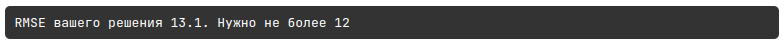

In [ ]:
results.append({
    'model_name': 'XGBRegressor',
    'tuning': False,
    'mean_kfold_score': 12.02,
    'leaderboard_score': 13.1,
    'model': default_xgb
})

### 2️⃣ CatBoostRegressor

In [ ]:
default_cb = CatBoostRegressor(verbose=0,
                               random_state=RANDOM_STATE).fit(X_train,
                                                              y_train,
                                                              eval_set=(X_test, y_test))

tested_pred = default_cb.predict(test_data)

pd.DataFrame({'car_id': test_df['car_id'], 'target_reg': tested_pred}).to_csv('submission_stepik_cb_baseline_default.csv', index=False)

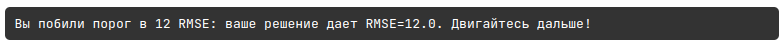

In [ ]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': False,
    'mean_kfold_score': 11.46,
    'leaderboard_score': 12.0,
    'model': default_cb
})

### 3️⃣ LGBMRegressor

In [ ]:
default_lgb = LGBMRegressor(verbose=-1,
                          random_state=RANDOM_STATE,
                          booster='goss').fit(X_train, y_train)

tested_pred = default_lgb.predict(test_data)

pd.DataFrame({'car_id': test_df['car_id'], 'target_reg': tested_pred}).to_csv('submission_stepik_lgb_baseline_default.csv', index=False)

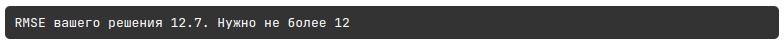

In [ ]:
results.append({
    'model_name': 'LGBMRegressor',
    'tuning': False,
    'mean_kfold_score': 11.9,
    'leaderboard_score': 12.7,
    'model': default_cb
})

Предварительно лучшей является модель CatBoostRegressor.

## 2️⃣ Feature Selection

Во второй части мы выделили наиболее важные признаки: `speed_max`, `mean_rating`, `distance_sum`, `rating_min`, `car_type`, `user_uniq`, `fuel_type` - оставим в тренировочной выборке только их.

In [ ]:
X_selected = train_df[['speed_max', 'mean_rating', 'distance_sum', 'rating_min', 'car_type', 'user_uniq', 'fuel_type']]
y_selected = train_df['target_reg']

In [ ]:
%%capture

baseline_models_with_selected_features = make_baseline_prediction(X_selected,
                                                                  y_selected)

In [ ]:
# оценим теперь качество на отобранных признаках

for i, result in enumerate(sorted(baseline_models_with_selected_features,
                                  key=lambda x: x[3]), start=1):
    print(f'{i}. Model: {result[0]}, encoder: {result[1]}, scaler: {result[2]}, RMSE: {result[3]}')

1. Model: CatBoostRegressor, encoder: OrdinalEncoder, scaler: StandardScaler, RMSE: 11.49352
2. Model: CatBoostRegressor, encoder: TargetEncoder, scaler: StandardScaler, RMSE: 11.49352
3. Model: CatBoostRegressor, encoder: LeaveOneOutEncoder, scaler: StandardScaler, RMSE: 11.49352
4. Model: CatBoostRegressor, encoder: OrdinalEncoder, scaler: MinMaxScaler, RMSE: 11.49371
5. Model: CatBoostRegressor, encoder: TargetEncoder, scaler: MinMaxScaler, RMSE: 11.49371
6. Model: CatBoostRegressor, encoder: LeaveOneOutEncoder, scaler: MinMaxScaler, RMSE: 11.49371
7. Model: CatBoostRegressor, encoder: OrdinalEncoder, scaler: RobustScaler, RMSE: 11.49377
8. Model: CatBoostRegressor, encoder: TargetEncoder, scaler: RobustScaler, RMSE: 11.49377
9. Model: CatBoostRegressor, encoder: LeaveOneOutEncoder, scaler: RobustScaler, RMSE: 11.49377
10. Model: CatBoostRegressor, encoder: no, scaler: no, RMSE: 11.49377
11. Model: XGBoost, encoder: OrdinalEncoder, scaler: MinMaxScaler, RMSE: 12.05407
12. Model: XGB

Качество незначительно упало, зато обучаемость выросла. Но так как есть смысл подобрать гиперпараметры через GridSearchCV или RandomizedSearchCV, будем работать с этими данными.

Так как по условиям задания нельзя работать с фреймворком Optuna и нельзя добавлять новые признаки (например, можно было бы `speed_max` разбить на 12 бинов - по правилу Фридмана-Дайнеса), то работаем с такими данными.

## 3️⃣ Object Selection

Так как у нас имеют выбросы в целевой переменной `target_reg` на графике Boxplot, то попробуем пролагорифмировать целевую переменную и отсеить выбросы, после чего посмотрим на качество нашей модели.

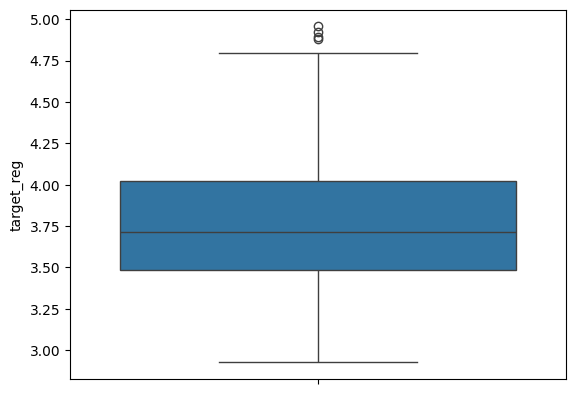

In [ ]:
# взглянем на BoxPlot после применения логарифмирования и применения клипинга - значения от 2.5 до 4.8
sns.boxplot(np.log1p(train_df['target_reg']))
plt.show();

In [ ]:
# посчитаем число выбросов

len(np.log1p(train_df['target_reg'])[np.log1p(train_df['target_reg']) > 4.8])

4

Попробуем несколько методов обработки выбросов и построим новые модели с печатью значений скоринга.

In [ ]:
# функция для обучения модели CatBoostRegressor

def catboost_reg(X, y, random_seed=RANDOM_STATE):

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        random_state=random_seed,
                                                        test_size=0.25)

    cat_cols_idx = [i for i, dtype in enumerate(X_train.dtypes) if dtype == 'object']

    cb_model = CatBoostRegressor(verbose=0,
                             early_stopping_rounds=150,
                             cat_features=cat_cols_idx,
                             random_state=RANDOM_STATE).fit(X_train,
                                                            y_train,
                                                            eval_set=(X_test, y_test))

    y_pred = cb_model.predict(X_test)
    rmse_score = mean_squared_error(y_test, y_pred) ** 0.5

    return rmse_score, cb_model

In [ ]:
# сразу применим кодировщики к тестовым данным

tested_df = test_df[['speed_max', 'mean_rating', 'distance_sum', 'rating_min', 'car_type', 'user_uniq', 'fuel_type']]

tested_transformer = Pipeline([
          ('encoder_', OrdinalEncoder(cols=tested_df.columns[tested_df.dtypes == 'object'])),
          ('scaler_', StandardScaler())])

tested_transformed_data = pd.DataFrame(tested_transformer.fit_transform(tested_df),
                                    columns=tested_transformer.named_steps['encoder_']
                                    .get_feature_names_out())

Для начала посмотрим качество прогноза на тестовых данных на стандартной модели CatBoostRegressor.

###  1️⃣ CatBoostRegressor

In [ ]:
# применение кодировщиков к отобранным данным и проведение прогноза на тестовых данных

baseline_data = encoder_scaler(X_selected, y_selected, 'OrdinalEncoder', 'StandardScaler')

baseline_model_cb_score, baseline_model_cb = catboost_reg(baseline_data,
                                                          y_selected)

tested_pred_log = baseline_model_cb.predict(tested_transformed_data)

pd.DataFrame({'car_id': test_df['car_id'], 'target_reg': tested_pred_log}).to_csv('submission_stepik_cb_baseline.csv', index=False)

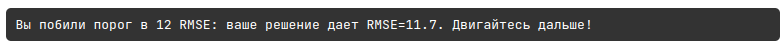

In [ ]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': False,
    'mean_kfold_score': 11.49,
    'leaderboard_score': 11.7,
    'model': baseline_model_cb
})

Порог в 12 RMSE побит, но попробуем улучшить качество без добавления новых признаков.

Так же обучим другие две модели и посмотрим на качество прогноза на лидерборде.

### 2️⃣ LGBMRegressor

In [ ]:
baseline_model_lgbm = LGBMRegressor(verbose=-1,
                          random_state=RANDOM_STATE,
                          booster='goss').fit(X_selected_transformed,
                                              y_selected)

tested_pred = baseline_model_lgbm.predict(tested_transformed_data)

pd.DataFrame({'car_id': test_df['car_id'], 'target_reg': tested_pred}).to_csv('submission_stepik_lgb_baseline.csv', index=False)

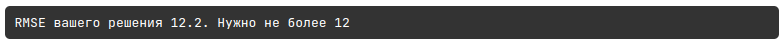

In [ ]:
results.append({
    'model_name': 'LGBMRegressor',
    'tuning': False,
    'mean_kfold_score': 12.05,
    'leaderboard_score': 12.2,
    'model': baseline_model_lgbm
})

In [ ]:
baseline_model_xgb = XGBRegressor(verbose=0,
                          random_state=RANDOM_STATE,
                          boosting_type='dart').fit(X_selected_transformed,
                                              y_selected)

tested_pred = baseline_model_xgb.predict(tested_transformed_data)

pd.DataFrame({'car_id': test_df['car_id'], 'target_reg': tested_pred}).to_csv('submission_stepik_xgb_baseline.csv', index=False)

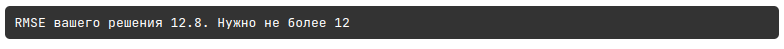

### 3️⃣ XGBRegressor

In [ ]:
results.append({
    'model_name': 'XGBRegressor',
    'tuning': False,
    'mean_kfold_score': 12.32,
    'leaderboard_score': 12.8,
    'model': baseline_model_xgb
})

## 4️⃣ Логарифмирование целевой переменной

Сначала попробуем применить логарифмирование, а затем применим к данным клипинг и посмотрим скоринг на модели. В качество модели выберем лидера среди всех baseline-моделей - CatBoostRegressor (OrdinalScaler + StandardScaler).

In [ ]:
%%capture

filtered_data_1 = X_selected.copy()

# обработка выбросов логарифмированием и клипингом (диапазон предварительно определили по графику)
filtered_data_1 = encoder_scaler(filtered_data_1, y_selected, 'OrdinalEncoder', 'StandardScaler')
filtered_data_1['target_reg'] = np.log(y_selected).clip(lower=2.5, upper=4.8)

baseline_models_with_log_y = train_model('CatBoostRegressor',
                                         filtered_data_1.drop('target_reg', axis=1),
                                         filtered_data_1['target_reg'],
                                         log_y=True)

In [ ]:
# оценим теперь качество

print('RMSE:', baseline_models_with_log_y[0])

RMSE: 11.47505


In [ ]:
# оценка прогноза для лидерборда

_, cb_model_log = catboost_reg(filtered_data_1.drop(['target_reg'], axis=1), filtered_data_1['target_reg'])
tested_pred_log = np.exp(cb_model_log.predict(tested_transformed_data))

pd.DataFrame({'car_id': test_df['car_id'], 'target_reg': tested_pred_log}).to_csv('submission_stepik_cb_log.csv', index=False)

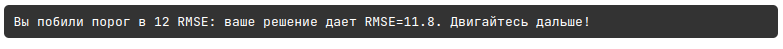

In [ ]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': False,
    'mean_kfold_score': 11.47,
    'leaderboard_score': 11.8,
    'model': cb_model_log
})

Качество прогноза снизилось. Теперь попробуем ещё один вариант - межквартильный размах.

## 5️⃣ Межквартильный размах

In [ ]:
%%capture

iqr_data = X_selected.copy()

# определение межквантильного размаха
q1 = y_selected.quantile(0.25)
q3 = y_selected.quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

filtered_data_2 = encoder_scaler(iqr_data, y_selected, 'OrdinalEncoder', 'StandardScaler')
filtered_data_2['target_reg'] = y_selected.copy()

# отсеиваем данные, после чего проверяем скоринг
filtered_data_2 = filtered_data_2[(filtered_data_2['target_reg'] > lower_bound) & (filtered_data_2['target_reg'] < upper_bound)].reset_index(drop=True)

baseline_models_with_iqr = train_model('CatBoostRegressor',
                                         filtered_data_2.drop('target_reg', axis=1),
                                         filtered_data_2['target_reg'])

In [ ]:
# оценим теперь качество

print('RMSE:', baseline_models_with_iqr[0])

RMSE: 10.15736


Качество удалось повысить. Теперь посмотрим на скоринг на Stepik на тестовых данных.

In [ ]:
_, cb_model_iqr = catboost_reg(filtered_data_2.drop('target_reg', axis=1), filtered_data_2['target_reg'])

tested_pred = cb_model_iqr.predict(tested_transformed_data)

pd.DataFrame({'car_id': test_df['car_id'], 'target_reg': tested_pred}).to_csv('submission_stepik_cb_iqr.csv', index=False)

На тестовых данных качество снова снизилось, но на тренировочных улучшилось. Это можем говорить о том, что наша модель больше переобучилась. Можно сделать вывод, что, возможно, мы теряем часть данных, когда применяем Object Selection, поэтому оставляем всё, как есть, то есть сырые данные, и будем подбирать параметры через RandomizedSearchCV.

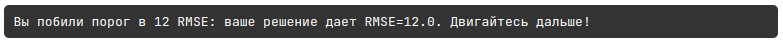

In [ ]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': False,
    'mean_kfold_score': 10.25,
    'leaderboard_score': 12.0,
    'model': cb_model_iqr
})

# 4️⃣ Подбор гиперпараметров

In [ ]:
%%capture

param_catboost = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0.5, 0.7, 0.9],
    'random_strength': [0.5, 0.7, 0.9],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bylevel': [0.5, 0.7, 0.9],
    'min_child_samples': [5, 10, 20, 30],
    'random_state': np.arange(1, 1000)
}

param_lgbm = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
    'min_child_samples': [5, 10, 20, 30],
    'random_state': np.arange(1, 1000)
}

param_xgb = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.3, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
    'min_child_weight': [1, 3, 5, 10],
    'objective': ['reg:squarederror'],
    'random_state': np.arange(1, 1000)
}

tested_transformer = Pipeline([
          ('encoder_', OrdinalEncoder(cols=tested_df.columns[tested_df.dtypes == 'object'])),
          ('scaler_', StandardScaler())])

X_selected_transformed = pd.DataFrame(tested_transformer.fit_transform(X_selected),
                                    columns=tested_transformer.named_steps['encoder_']
                                    .get_feature_names_out())

catboost_params_after_tuning, catboost_score = RandomSearchCV(X_selected_transformed, y_selected, param_catboost, CatBoostRegressor(thread_count=-1, verbose=0))
lgbm_params_after_tuning, lgbm_score = RandomSearchCV(X_selected_transformed, y_selected, param_lgbm, LGBMRegressor(thread_count=-1, verbosity=-1))
xgb_params_after_tuning, xgb_score = RandomSearchCV(X_selected_transformed, y_selected, param_xgb, XGBRegressor(thread_count=-1, verbosity=0))

In [ ]:
print(f'RMSE CatBoostRegressor: {catboost_score}, \nRMSE LGBRegressor: {lgbm_score}, \nRMSE XGBRegressor: {xgb_score}')

RMSE CatBoostRegressor: 12.998375283603165, 
RMSE LGBRegressor: 13.977256145901583, 
RMSE XGBRegressor: 14.750704987326728


In [ ]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': True,
    'mean_kfold_score': 12.8,
    'leaderboard_score': '-',
    'model': '-'
})

results.append({
    'model_name': 'LGBMRegressor',
    'tuning': True,
    'mean_kfold_score': 14.22,
    'leaderboard_score': '-',
    'model': '-'
})

results.append({
    'model_name': 'XGBRegressor',
    'tuning': True,
    'mean_kfold_score': 15.53,
    'leaderboard_score': '-',
    'model': '-'
})

При подборе гипрпараметров качество прогноза упало на всех моделях, поэтому в целях экономии времени не будем проверять качество на лидерборде. Попробуем тепрь подобрать значение random_state, чтобы на модели CatBoostRegressor качество выросло настолько, насколько возможно. Так же попробуем изменить тип `boosting_type` у модели XGBoost и `booster` у модели LightGBM.

# 5️⃣ Дополнительный подбор параметров

## 1️⃣ CatBoostRegressor

Попробуем подобрать `random_seed` для модели CatBoostRegressor, качество будем проверять на кросс-валидации.

In [ ]:
best_rmse = 1000
random_param = 9999

for _ in range(50):
    random_seed = np.random.randint(1000)
    rmse_score, _ = train_model('CatBoostRegressor',
                                X_selected_transformed,
                                y_selected,
                                random_seed=random_seed)

    if rmse_score < best_rmse:
        best_rmse = rmse_score
        random_param = random_seed
        print('RMSE:', rmse_score)

RMSE: 11.53018
RMSE: 11.51382
RMSE: 11.51238
RMSE: 11.48364
RMSE: 11.48031
RMSE: 11.46993


In [ ]:
_, cb_model_random = catboost_reg(X_selected_transformed, y_selected, random_seed=random_param)

tested_pred = cb_model_random.predict(tested_transformed_data)

pd.DataFrame({'car_id': test_df['car_id'], 'target_reg': tested_pred}).to_csv('submission_stepik_cb_random_state.csv', index=False)

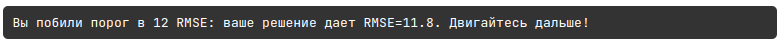

In [ ]:
results.append({
    'model_name': 'CatBoostRegressor',
    'tuning': True,
    'mean_kfold_score': 11.46,
    'leaderboard_score': 11.8,
    'model': cb_model_random
})

Качество сильно не изменилось. Попробуем теперь обучить модели XGBoost и LightGBM с другими типами бустинга.

## 2️⃣ LGBMRegressor

In [ ]:
lgbm_dart_score, _ = train_model('LightGBM',
                                 X_selected_transformed,
                                 y_selected,
                                 init_params={'booster': 'dart',
                                              'random_state': RANDOM_STATE,
                                              'verbosity': -1})

print('RMSE of LightGBM (dart):', lgbm_dart_score)

RMSE of LightGBM (dart): 12.32313


In [ ]:
lgbm_dart = LGBMRegressor(verbose=-1,
                          random_state=RANDOM_STATE,
                          booster='dart').fit(X_selected_transformed,
                                              y_selected)

tested_pred = lgbm_dart.predict(tested_transformed_data)

pd.DataFrame({'car_id': test_df['car_id'], 'target_reg': tested_pred}).to_csv('submission_stepik_lgbm_dart.csv', index=False)

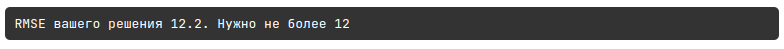

In [ ]:
results.append({
    'model_name': 'LGBMRegressor',
    'tuning': 'dart',
    'mean_kfold_score': 12.32,
    'leaderboard_score': 12.2,
    'model': lgbm_dart
})

## 3️⃣ XGBRegressor

In [ ]:
xgb_gbtree_score, _ = train_model('XGBoost',
                                  X_selected_transformed,
                                  y_selected,
                                  init_params={'boosting_type': 'gbtree',
                                               'random_state': RANDOM_STATE,
                                               'verbosity': 0})

print('RMSE of XGBoost (dart):', xgb_gbtree_score)

RMSE of XGBoost (dart): 12.05407


In [ ]:
xgb_gbtree = XGBRegressor(verbose=0,
                         random_state=RANDOM_STATE,
                         boosting_type='gbtree').fit(X_selected_transformed,
                                                     y_selected)

tested_pred = xgb_gbtree.predict(tested_transformed_data)

pd.DataFrame({'car_id': test_df['car_id'], 'target_reg': tested_pred}).to_csv('submission_stepik_xgb_gbtree.csv', index=False)

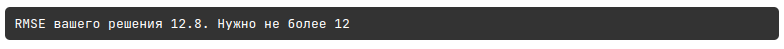

In [ ]:
results.append({
    'model_name': 'XGBRegressor',
    'tuning': 'gbtree',
    'mean_kfold_score': 12.05,
    'leaderboard_score': 12.8,
    'model': xgb_gbtree
})

Лучшее значение скоринга RMSE даёт baseline-модель CatBoostRegressor, поэтому выберём её в качестве лучшей из всех.

# 6️⃣ Выводы

In [ ]:
results = pd.DataFrame(results)
results

,model_name,tuning,mean_kfold_score,leaderboard_score,model
0,XGBRegressor,False,12.02,13.1,"XGBRegressor(base_score=None, booster=None, bo..."
1,CatBoostRegressor,False,11.46,12.0,<catboost.core.CatBoostRegressor object at 0x7...
2,LGBMRegressor,False,11.90,12.7,<catboost.core.CatBoostRegressor object at 0x7...
3,CatBoostRegressor,False,11.49,11.7,<catboost.core.CatBoostRegressor object at 0x7...
4,LGBMRegressor,False,12.05,12.2,"LGBMRegressor(booster='goss', random_state=73,..."
5,XGBRegressor,False,12.32,12.8,"XGBRegressor(base_score=None, booster=None, bo..."
6,CatBoostRegressor,False,11.47,11.8,<catboost.core.CatBoostRegressor object at 0x7...
7,CatBoostRegressor,False,10.25,12.0,<catboost.core.CatBoostRegressor object at 0x7...
8,CatBoostRegressor,True,12.80,-,-
9,LGBMRegressor,True,14.22,-,-


*   Лучшией модель оказалась CatBoostRegressor (OrdinalEncoder, StantardScaler) с автоматически подбираемыми параметрыми с признаками: `speed_max`, `mean_rating`, `distance_sum`, `rating_min`, `car_type`, `user_uniq`, `fuel_type`;
*   Качество лучшей модели RMSE = 11.7 на лидерборде;
*   Нам не помог Object Selection (логарифмирование и межквартильный размах) - это лишь ухудшило качество модели на кросс-валидации;
*   Так как по заданию нельзя добавлять новые признаки и нельзя пользоваться Optuna для подбора гиперпараметров, то больше делать с моделью и датасетом нечего;
*   Остальные модели показали результ хуже, им ничто не помогло преодолеть порог в RMSE = 12 на лидерборде;
*   Построенные графики в рамках Feature Selection помогли нам отобрать лучшие признаки, по итогам 6 разных методов мы это и сделали;
*   Благодаря графику распределения целевой переменной, мы определили логнормальный характер распределения, однако логарифмирование не дало требуемых результатов, скорее всего, потому что мы теряли часть важных данных.

